# Beijing Air Quality Forecasting Starter Notebook

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LSTM, Dense,Dropout, Bidirectional,BatchNormalization
import tensorflow as tf
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [3]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB


In [5]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [6]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [7]:
train.isnull().sum()


,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


In [8]:
test.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


In [9]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


In [10]:
train.isnull().sum()


,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


## Visualing train data to find insights

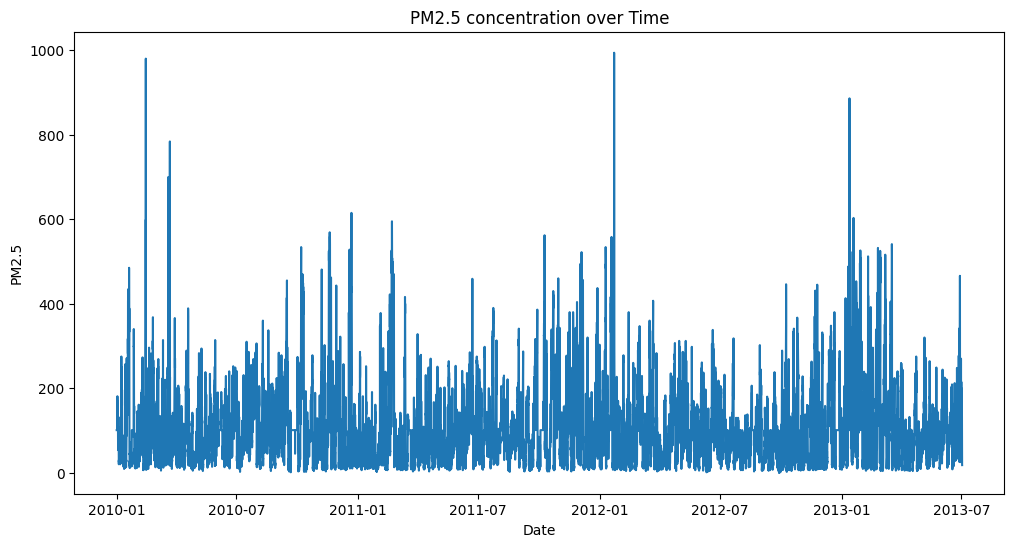

In [11]:
plt.figure(figsize=(12,6))
plt.plot(train.index,train['pm2.5'],label='PM2.5')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('PM2.5 concentration over Time')
plt.show()

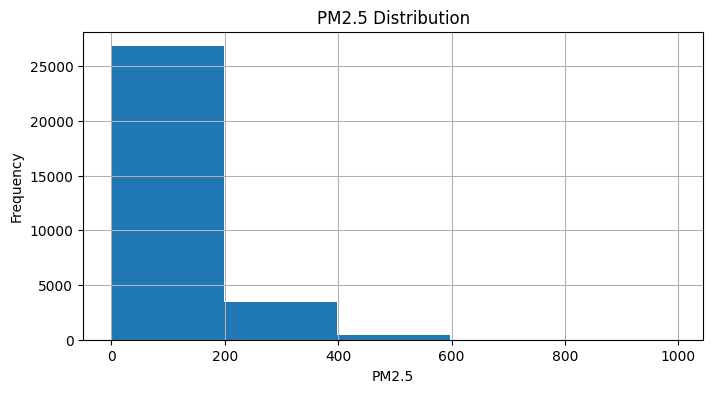

In [12]:
#Visualizing the distribution of PM2.5 Values
train["pm2.5"].hist(bins=5,figsize=(8,4))
plt.title('PM2.5 Distribution')
plt.xlabel("PM2.5")
plt.ylabel('Frequency')
plt.show()

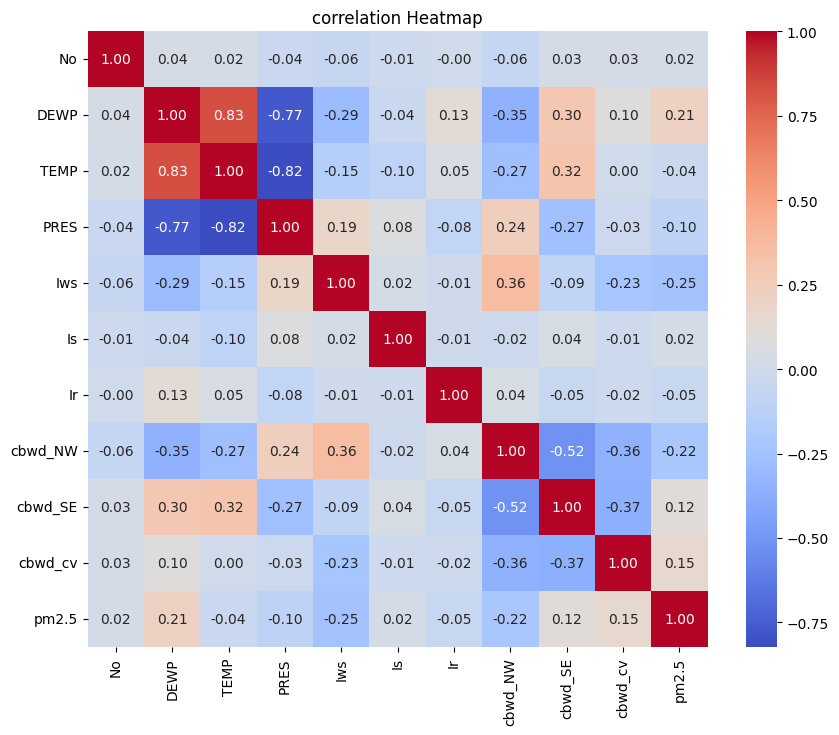

In [13]:
plt.figure(figsize=(10,8))
correlation = train.corr(numeric_only= True)
sns.heatmap(correlation,annot=True,cmap="coolwarm",fmt='.2f')
plt.title('correlation Heatmap')
plt.show()

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [14]:
test.head(5)

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv
datetime,,,,,,,,,,
2013-07-02 04:00:00,30677,1.190496,0.701029,-2.186052,-0.003982,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2013-07-02 05:00:00,30678,1.121211,0.619051,-2.186052,0.031811,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2013-07-02 06:00:00,30679,1.190496,0.783006,-2.186052,0.094398,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2013-07-02 07:00:00,30680,1.190496,0.946961,-2.088668,0.174782,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2013-07-02 08:00:00,30681,1.190496,1.192893,-1.991283,0.210575,-0.069353,-0.137667,1.448138,-0.732019,-0.522096


In [15]:
test.shape

(13148, 10)

In [16]:
train.shape

(30676, 11)

In [17]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']
X_test = test.drop(['No'], axis=1)

In [18]:
#Normalize features
scaler =StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled =scaler.fit_transform(X_test)

In [19]:
# Reshape data for LSTM input
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)
X_test_scalaed = np.expand_dims(X_test_scaled, axis=1)

In [20]:
# Split data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_scaled, y_train, test_size=0.2, shuffle=False)


In [21]:
X_train_split.shape

(24540, 1, 9)

In [22]:
X_val_split.shape

(6136, 1, 9)

In [23]:
print(np.isnan(X_train_split).sum())
print(np.isnan(y_train_split).sum())

0
0


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [41]:
# define model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, activation='tanh', kernel_regularizer=l2(0.01)), input_shape=(X_train_split.shape[1], X_train_split.shape[2])),
    Dropout(0.4),
    LSTM(32, activation='tanh', recurrent_dropout=0.2),
    Dropout(0.4),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer= Adam(learning_rate=0.0001),
    loss='mse',
)

# Display the model architecture
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ (None, 1, 128)         │        37,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,529 (228.63 KB)

 Trainable params: 58,529 (228.63 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Train the model
# You can adjust the number of epochs and batch size to improve performance.
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
# start time for the model training
start_time = time.time()

# Train the model
start_time = time.time()

history = model.fit(
    X_train_split, y_train_split,
    epochs=200,
    batch_size=64,
    validation_data=(X_val_split,y_val_split),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 16115.3682 - val_loss: 22581.8770 - learning_rate: 1.0000e-04
Epoch 2/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 15607.6211 - val_loss: 21978.3750 - learning_rate: 1.0000e-04
Epoch 3/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 15084.9795 - val_loss: 21421.3125 - learning_rate: 1.0000e-04
Epoch 4/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 14936.1309 - val_loss: 21057.2266 - learning_rate: 1.0000e-04
Epoch 5/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 15000.1494 - val_loss: 20781.9199 - learning_rate: 1.0000e-04
Epoch 6/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 14176.7031 - val_loss: 20547.2539 - learning_rate: 1.0000e-04
Epoch 7/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 14178.0850 - val_loss: 20334.3691 - learning_rate: 1.0000e-04
Epoch 8/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 13749.9863 - val_loss: 20135.5762 - learning_rate: 1.0000e-04
Epoch 9/200
384

Training Time: 769.21 seconds
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


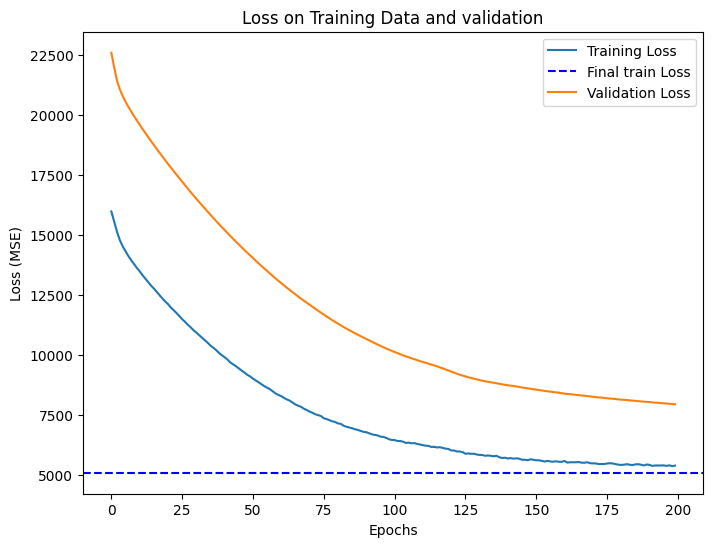

Final Training Loss (MSE): 5107.852795515222


In [44]:

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Calculate training loss
train_predictions = model.predict(X_train_split)
train_loss = np.mean((y_train_split - train_predictions.flatten())**2)
val_predictions = model.predict(X_val_split)
# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final train Loss')  # Final training loss
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss on Training Data and validation')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [45]:
#Loss and RMSE
train_loss = mean_squared_error(y_train_split, train_predictions)
val_loss = mean_squared_error(y_val_split, val_predictions)
RMSE = np.sqrt(train_loss)

print(f'Training Loss (MSE): {train_loss:.4f}')
print(f'Validation Loss (MSE): {val_loss:.4f}')
print(f'Root Mean Squared Error (RMSE): {RMSE:.4f}')

Training Loss (MSE): 5107.8528
Validation Loss (MSE): 7952.8894
Root Mean Squared Error (RMSE): 71.4692


In [47]:

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
#X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

predictions = model.predict(X_test_scaled)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('subm_fixed_10.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
